# Assignment 1 - Unsupervised learning
### Sanna Hartman Sellæg, Nima Salihzada, Tarjei Åkre Reite


This assignment explores a data set with customer data, and attempts to create clusters in the data that can reveal interesting information about different customer profiles.

#### Contents
0. Load data and imports
1. Data preparation
2. Choosing number of clusters
3. Train k-means models
4. Analyze clusters
5. Profiling
6. Dimensionality reduction

### 0. Load data and imports

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
#from kneed import KneeLocator


df = pd.read_csv('customer_data_large.csv')

### 1. Data preparation

Checking for missing data.

In [27]:
missing_values = df.isnull().sum()
question_mark_values = (df == '?').sum()

if missing_values.sum() > 0 or question_mark_values.sum() > 0:
    print("Missing or invalid values found.")
else:
    print("No missing or invalid values found.")

No missing or invalid values found.


Apply a scaler to the data.

In [28]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

### 2. Choosing number of clusters

Finding the correct number of clusters can be challenging, and to it requires evaluation metrics that do not need labeled data. For this assignment, the following methods will be examined (https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation):
1. SSE - Sum of Squared Error
2. Silhouette score
3. Calinski-Harabasz Index
4. Davies-Bouldin Index

First, try with several different values for k to find out which one(s) are best.

In [29]:
number_of_k_to_test = 20

sse = []
silhouette_scores = []
calinski_harabasz = []
davies_bouldin = []
for i in range(2, number_of_k_to_test):
    km = KMeans(n_clusters=i, random_state=19)
    km.fit(df_scaled)
    sse.append(km.inertia_)
    silhouette_scores.append(silhouette_score(df_scaled, km.labels_))
    calinski_harabasz.append(calinski_harabasz_score(df_scaled, km.labels_))
    davies_bouldin.append(davies_bouldin_score(df_scaled, km.labels_))

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

The Sum of Squared Error (sse) for each k is then plotted.

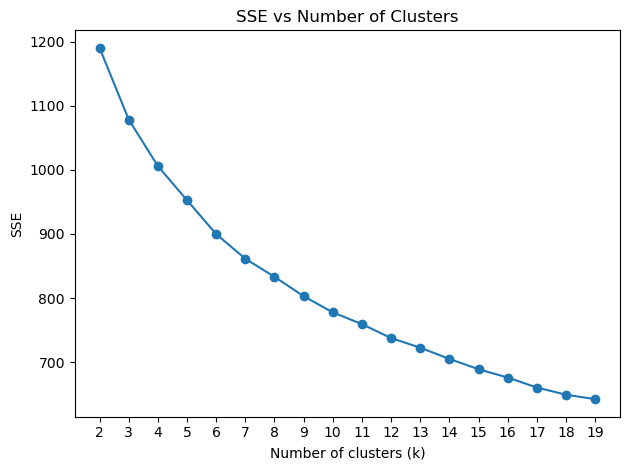

In [30]:
k_values = list(range(2, number_of_k_to_test))

plt.figure()
plt.plot(k_values, sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE')
plt.title('SSE vs Number of Clusters')
plt.xticks(k_values)
plt.tight_layout()
plt.show()



By looking at the plot of the errors against the number of clusters, the elbow method can be applied. This involves looking for the point where the rate of improvement starts to slow down when adding more clusters, which can look like the elbow of an arm.

Visually, it seems like the elbow might be somewhere between 7-10 clusters.

Alternatively, an imported library, kneed, has ha function that finds the elbow point. Since this function returns 8, that could indicate that 7-10 clusters was a good estimate.

In [ ]:
knee_locator = KneeLocator(range(2, number_of_k_to_test), sse, curve="convex", direction="decreasing")
optimal_k = knee_locator.knee

print(f"The optimal number of clusters is: {optimal_k}")

Next we plot the silhouette coefficients, where a higher score means that the model has better defined clusters.

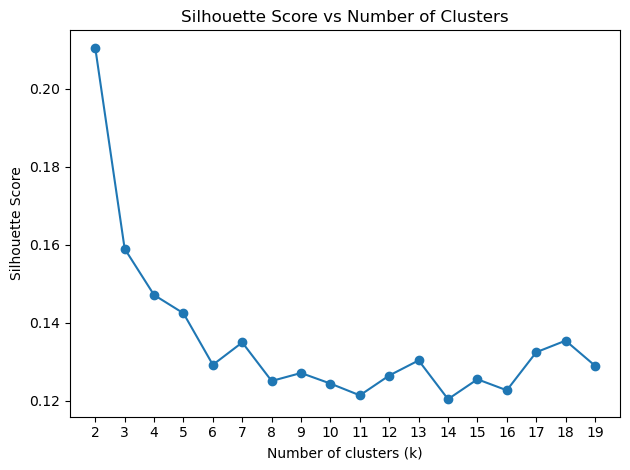

In [31]:
plt.figure()
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.xticks(k_values)
plt.tight_layout()
plt.show()

Based on the silhouette coefficients, it looks like the clarity of the clusters stabilize somewhat on the values between 8 and 16. 

Now the Calinski-Harabasz Index values are plottet.

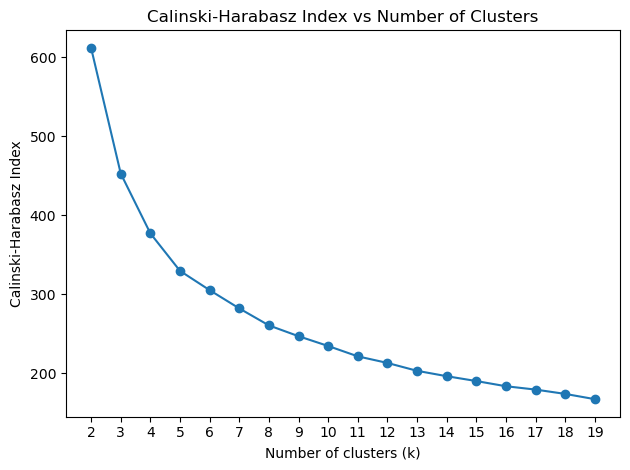

In [32]:
plt.figure()
plt.plot(k_values, calinski_harabasz, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index vs Number of Clusters')
plt.xticks(k_values)
plt.tight_layout()
plt.show()

It is hard to read anything conclusive from the Calinski-Harabasz values. Typically, higher values mean that the clusters are dense and well separated. It seems like adding more clusters do not improve neither the density or the separation.

Finally, the Davies‑Bouldin Index values:

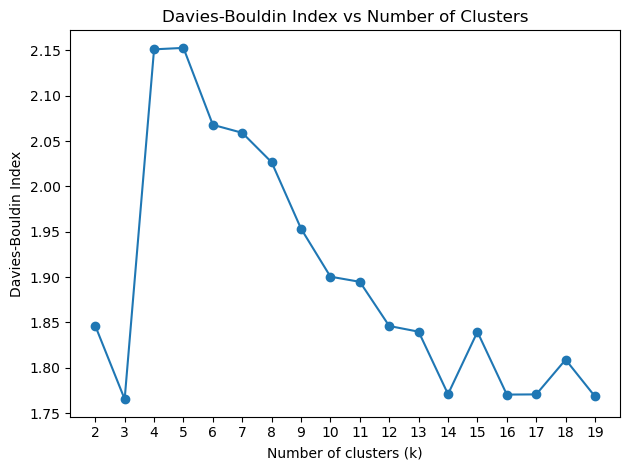

In [33]:
plt.figure()
plt.plot(k_values, davies_bouldin, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index vs Number of Clusters')
plt.xticks(k_values)
plt.tight_layout()
plt.show()

The Davies-Bouldin values are lower the better the cluster partition is. There seems to be a local minimum between 8 and 12, before the values go even lower at 16. There is also a very low value at 2.

#### Summary of results

Four metrics have been used to evaluate how many clusters should be included in the k-means model. A SSE approach indicated that a value around 7-10 could be a good pick, which was further backed up by the silhouette scores, that showed that values between 8 and 16 could be fairly well considerations. Then, not much was learned from the Calinsi-Harabasz scores, but the Davies-Bouldin scores further indicated that a value around 8 clusters could be a good pick.
It should be noted that some numbers of clusters gave even better scores in some of the metrics, like 16 in the Davies-Bouldin metrics, but it is probably not desirable to continue with such a high number of clusters. The lowest number of clusters that seem to give sensible scores look like 8-9.

##### Averaging out randomness in results

As a side note it is useful to consider the fact that the random seed that was chosen (19) could be a statistical outlier, and that the nature of the data in reality is quite different. To explore this, we wrote code that averaged out fifty different random states to see how the results changed.

In [34]:
number_of_k_to_test = 20

sse = []
silhouette_scores = []
calinski_harabasz = []
davies_bouldin = []
for i in range(2, number_of_k_to_test):
    sse_sum = 0
    silhouette_sum = 0
    calinski_sum = 0
    davies_sum = 0
    for r in range(50): # 50 random states
        km = KMeans(n_clusters=i, random_state=r)
        km.fit(df_scaled)
        sse_sum += km.inertia_
        silhouette_sum += silhouette_score(df_scaled, km.labels_)
        calinski_sum += calinski_harabasz_score(df_scaled, km.labels_)
        davies_sum += davies_bouldin_score(df_scaled, km.labels_)
    sse.append(sse_sum / 50)
    silhouette_scores.append(silhouette_sum / 50)
    calinski_harabasz.append(calinski_sum / 50)
    davies_bouldin.append(davies_sum / 50)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

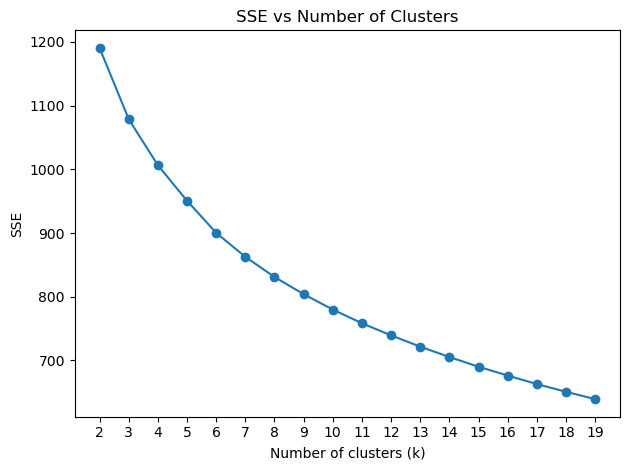

In [35]:
k_values = list(range(2, number_of_k_to_test))

plt.figure()
plt.plot(k_values, sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE')
plt.title('SSE vs Number of Clusters')
plt.xticks(k_values)
plt.tight_layout()
plt.show()

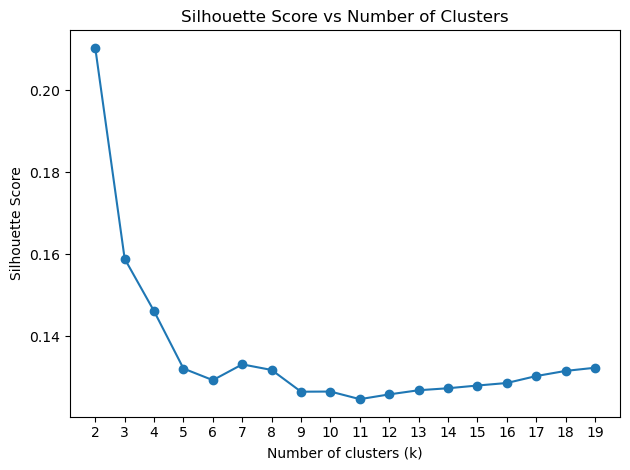

In [36]:
plt.figure()
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.xticks(k_values)
plt.tight_layout()
plt.show()

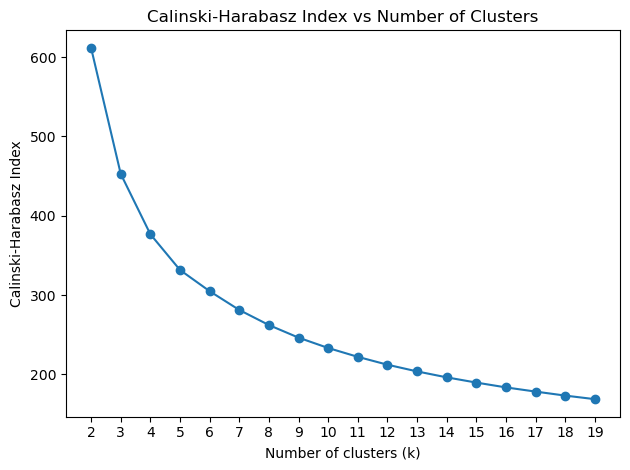

In [37]:
plt.figure()
plt.plot(k_values, calinski_harabasz, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index vs Number of Clusters')
plt.xticks(k_values)
plt.tight_layout()
plt.show()

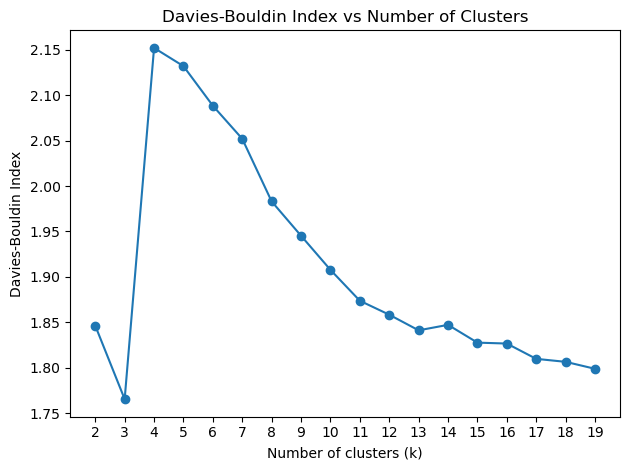

In [38]:
plt.figure()
plt.plot(k_values, davies_bouldin, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index vs Number of Clusters')
plt.xticks(k_values)
plt.tight_layout()
plt.show()

##### Interpreting the average of fifty random states
Perhaps expectedly, the average results are much more smooth than the single simulation based on the random seed 19. Looking at the results it is hard to conclude whether or not the prior estimate of having 8-9 clusters is a good and representative choice. The sum of the squared errors has a very smooth curve, and finding the elbow seems to very much depend on the amount of clusters chosen to include in the simulation. The silhouette scores and the Davies-Bouldin scores seem to indicate that after the first few clusters 2-4 adding more clusters lead to a continuous decrease of performance.

To find out what candidates should be examined further, it would be interesting to see how the clusters are distributed if there are both few and many clusters. Therefore, 2 and 8 clusters will be examined.

### 3. Train the k-means models
Now, we make a k-means model for every candidate cluster number.

In [39]:
km2  = KMeans(n_clusters=2,  random_state=19)
km8  = KMeans(n_clusters=8,  random_state=19)

km2.fit( df_scaled)
km8.fit( df_scaled)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(random_state=19)

### 4. Analyze clusters
Now we take a look at the centroids of the different models.

In [40]:
centers8 = pd.DataFrame(km8.cluster_centers_,columns=df_scaled.columns)
centers_unscaled8 = pd.DataFrame(scaler.inverse_transform(centers8),index=centers8.index,columns=centers8.columns)
centers_unscaled8.loc['std_dev (standardized)'] = centers8.std()
centers_unscaled8

,Education,Kidhome,Recency,MntWines,MntFruits,MntSweetProducts,MntGoldProds,NumWebPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Years_customer,Num_AcceptedCmp,MntFishMeatProdcts
0,3.791667,0.083333,46.779762,881.541667,50.660714,52.041667,67.767857,7.273810,8.761905,8.744048,47.148810,8.755952,2.261905,486.410714
1,3.284247,0.636986,20.595890,93.582192,6.589041,8.791096,26.684932,3.921233,3.705479,8.321918,45.811644,8.989726,0.277397,66.061644
2,3.203704,0.037037,35.552469,447.126543,71.984568,69.626543,84.793210,5.987654,9.154321,4.740741,57.811728,8.722222,0.330247,419.608025
3,3.516779,0.852349,44.395973,52.973154,4.724832,4.691275,12.224832,3.137584,3.369128,7.583893,49.691275,8.000000,0.174497,34.110738
4,3.622407,0.074689,52.917012,690.170124,50.352697,55.456432,72.087137,6.639004,8.597510,6.493776,54.850622,10.000000,0.817427,410.190871
5,3.911681,0.011396,71.202279,378.846154,20.105413,22.139601,44.934473,5.113960,6.612536,4.717949,58.074074,8.680912,0.219373,220.928775
6,3.118367,0.706122,47.102041,97.465306,9.334694,8.934694,34.004082,4.457143,3.795918,9.057143,45.461224,10.000000,0.306122,79.995918
7,3.282958,1.061093,69.893891,60.655949,6.221865,6.022508,19.344051,3.475884,3.466238,8.723473,45.077170,8.987138,0.080386,41.672026
std_dev (standardized),0.072452,0.213119,0.169049,0.213133,0.132012,0.100147,0.074006,0.047386,0.201701,0.089024,0.101562,0.339984,0.144509,0.110937


In [41]:
centers2 = pd.DataFrame(km2.cluster_centers_,columns=df_scaled.columns)
centers_unscaled2 = pd.DataFrame(scaler.inverse_transform(centers2),index=centers2.index,columns=centers2.columns)
centers_unscaled2.loc['std_dev (standardized)'] = centers2.std()
centers_unscaled2

,Education,Kidhome,Recency,MntWines,MntFruits,MntSweetProducts,MntGoldProds,NumWebPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Years_customer,Num_AcceptedCmp,MntFishMeatProdcts
0,3.588121,0.050633,49.909445,576.208374,49.778968,51.111977,70.763389,6.322298,8.450828,5.884129,55.601753,9.051607,0.740993,385.387537
1,3.348296,0.780549,48.534497,71.789692,6.198670,6.627598,20.873649,3.588529,3.529510,8.150457,46.960931,8.904406,0.193682,50.118869
std_dev (standardized),0.042395,0.258064,0.009821,0.238900,0.154854,0.119602,0.097451,0.060408,0.267684,0.080127,0.111091,0.052043,0.077401,0.137353


##### Which variables are important to distinguish between clusters?

To determine which features are most important in separating the clusters, we calculated the **standard deviation across cluster centroids** (in standardized form). The logic is that if a feature has large variation between centroids, it plays a more central role in distinguishing between groups.

The bar chart below shows the standard deviation of each feature across the 8 clusters:

- The feature with the **highest variation** is `Years_customer`, suggesting that the length of time a customer has been with the company is a strong differentiating factor.
- This is followed by `MntWines`, `Kidhome`, and `NumStorePurchases`, which also contribute significantly to the clustering.
- On the other hand, variables such as `NumWebPurchases`, `Education`, and `MntGoldProds` have low variation between clusters, and therefore seem to have **less influence** on the cluster separation.

This information helps us focus interpretation on the variables that actually define the structure of the clusters.


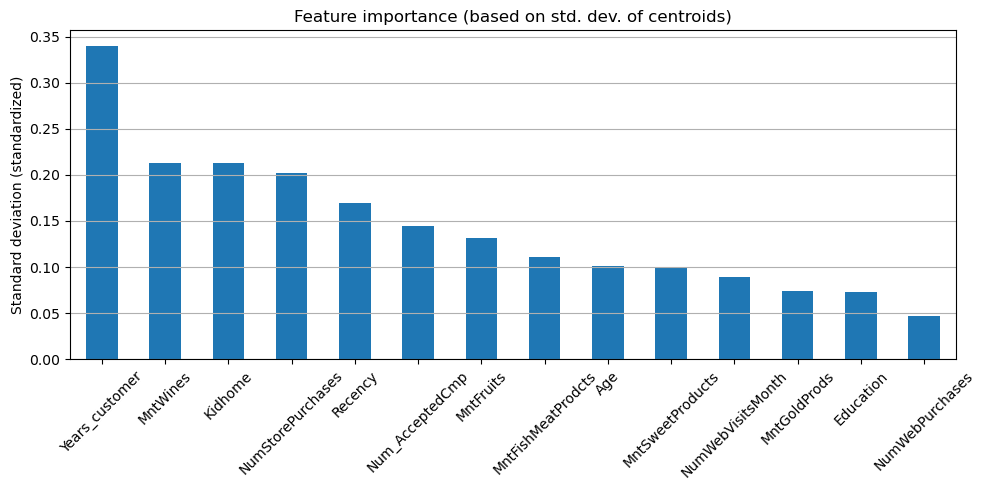

In [43]:
std_devs = centers8.std().sort_values(ascending=False)

plt.figure(figsize=(10,5))
std_devs.plot(kind='bar')
plt.title('Feature importance (based on std. dev. of centroids)')
plt.ylabel('Standard deviation (standardized)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### 5 - Profiling
By looking at the centroids, we can see a few interesting trends and attempt to create some customer profiles. Looking at the 2-cluster centroids, it is apparent that we can divide the customers into two main groups, with some key differences.
* Group 1 - This group spends much money for every time they go shopping. They tend to not have kids and they often accept campaigns.
* Group 2 - This group spends less money and they have more kids. They also do not accept campaigns nearly as much. However, they visit the store on the web more often.

It seems like the customers can be divided into two main groups, the shoppers and the non-shoppers. The shoppers will come into the store more often, both on online and to the physical store. The non-shoppers come in more seldom and spend less money. They also do not care as much about the advertising campaigns. They visit the web more often, perhaps indicative of a more price-conscious pattern, where they check often for good deals.

### 6 - Dimensionality reduction

In [ ]:
pca = PCA()
pca.fit(df_scaled)
df_pca = pca.transform(df_scaled)

In [ ]:
lcolumns = []
for i in range (1,df_scaled.shape[1]+1):
  lcolumns.append('pc' + str(i))
df_pca = pd.DataFrame(df_pca, columns = lcolumns,index=df_scaled.index)
df_pca

In [ ]:
plt.figure(figsize=(6,6))
sns.scatterplot( x='pc1', y='pc2',s=60,
  data=df_pca,legend=True)

The plot above is a scatterplot of the two most significant principal components in the data. The data shows clearly three clusters of points, which might suggest that there are three clusters in the data. To further explore how this data fits with the clusters found in the k-means approach, we can plot this scatterplots with colors corresponding to the different clusters from k-means.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

models = [km2, km8]
titles = ['K-Means (k=3)', 'K-Means (k=4)']

for i, (model, ax) in enumerate(zip(models, axes)):
    df_pca['Cluster'] = model.labels_
    sns.scatterplot(
        x='pc1', y='pc2', hue='Cluster', palette='viridis', data=df_pca, ax=ax, legend=None
    )
    ax.set_title(titles[i])
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

#### t-SNE
Applying t-SNE to the data set is helpful to visualize clusterings in the data. The algorithm attempts to project higher dimensional data into lower dimention space. In short, the algorithm tries to make sure that points that are close together in the high dimensional space remain close together in the low-dimension projection. However, the actual structure of the data is not retained, so it is not possible to say anything meaningful about the actual distances between points based on the t-SNE projection. The projection is more useful to visualize clustering in the data.

The algorithm depends on a hyperparameter called perplexity, which is a number that states how many of the nearby points a given point should consider when modelling proximity. A lower hyperparameter is better at capturing local patterns, whereas a larger value can capture more global groupings.

In [ ]:
tsne = TSNE()
df_tsne = tsne.fit_transform(df_scaled)
dicc_tsne = {'comp_1':df_tsne[:,0],'comp_2':df_tsne[:,1]}
df_tsne = pd.DataFrame(dicc_tsne,index=df_scaled.index)

In [ ]:
plt.figure(figsize=(6,6))
sns.scatterplot(data=df_tsne, x='comp_1',y='comp_2', legend='full')

In [ ]:
for perp in [5,10,20,30,50,100,1000,2000]:
  tsne = TSNE(perplexity=perp,random_state=72)
  X_tsne = tsne.fit_transform(df_scaled)
  dicc_tsne = {'comp_1':X_tsne[:,0],'comp_2':X_tsne[:,1]}
  df_tsne = pd.DataFrame(dicc_tsne,index=df_scaled.index)
  plt.figure(figsize=(6,6))
  plt.title('Perplexity = ' + str(perp))
  sns.scatterplot(data=df_tsne, x='comp_1',y='comp_2', legend='full')

The various different scatterplots show how the clusters wary with different perplexities. With a very high perplexity it looks like three distinct groups are forming, similarly to the PCA approach. To compare that with the four different candidate clusters from k-means, we can plot the clusters on the scatterplot:

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

models = [km2, km8]
titles = ['K-Means (k=2)', 'K-Means (k=8)']

tsne = TSNE(perplexity=1000, random_state=72)
X_tsne = tsne.fit_transform(df_scaled)
df_tsne = pd.DataFrame({
    'comp_1': X_tsne[:, 0],
    'comp_2': X_tsne[:, 1]
}, index=df_scaled.index)


for i, (model, ax) in enumerate(zip(models, axes)):
    df_tsne['Cluster'] = model.labels_
    sns.scatterplot(
        x='comp_1', y='comp_2',
        hue='Cluster', palette='viridis',
        data=df_tsne, ax=ax, legend=None
    )
    ax.set_title(titles[i])

plt.tight_layout()
plt.show()

Similarly to PCA, the found clusters do not correspond very well with the k-means clusters. One possible explaination for this is that the clusters that PCA and t-SNE are able to identify are somewhat non-linear of nature, which means that k-means will have a hard time properly defining them.

As a last test, we will see how the k-means clusters fit with t-SNE models with lower perplexity and more clusters.

In [ ]:
tsne = TSNE(perplexity=100, random_state=72)
X_tsne = tsne.fit_transform(df_scaled)
X_tsne_unscaled = tsne.fit_transform(df)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
models = [km2, km8]
titles = ['K-Means (k=2)', 'K-Means (k=8)']
df_tsne = pd.DataFrame({
    'comp_1': X_tsne[:, 0],
    'comp_2': X_tsne[:, 1]
}, index=df_scaled.index)


for i, (model, ax) in enumerate(zip(models, axes)):
    df_tsne['Cluster'] = model.labels_
    sns.scatterplot(
        x='comp_1', y='comp_2',
        hue='Cluster', palette='viridis',
        data=df_tsne, ax=ax, legend=None
    )
    ax.set_title(titles[i])

plt.tight_layout()
plt.show()

As we can see, the clusters in k-means do not correspond very well with the clusters in t-SNE. One possible reason for the mismatch between the clusters in k-means and the clusterings in the t-SNE projection is that the clusters have too complex shapes to be properly captured by k-means.